In [1]:
import mdtraj as md 
from ase import Atoms
from nglview import show_ase
import networkx as nx

import torch
import torch_geometric.transforms as T
from torch_geometric.loader import DataLoader
from torch_geometric.nn import  GCNConv,BatchNorm
import torch_geometric.data as data
from torch_geometric.utils.convert import to_networkx

import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.optim.lr_scheduler as lr_scheduler
from sklearn.preprocessing import MinMaxScaler

In [2]:
# load alanine dipeptide trajectory 
molecule = md.load_pdb("../simulation/single.pdb")

In [3]:
atomic_nums = [atom.element.atomic_number for atom in molecule.top.atoms] 
water = Atoms(positions= molecule.xyz[0], numbers=atomic_nums)
show_ase(water)

NGLWidget()

In [4]:
molecule.xyz*10

array([[[ 0.        ,  0.        ,  0.        ],
        [ 0.957     ,  0.        ,  0.        ],
        [-0.23900001,  0.926     ,  0.        ],
        [ 0.        ,  0.46      ,  0.32000002]]], dtype=float32)

In [5]:
def rotate3D(features,psi,theta,phi):
    xyz = features[:,:3]
    rest = features[:,3:]
    matrix = np.array([[np.cos(psi)*np.cos(phi)-np.cos(theta)*np.sin(phi)*np.sin(psi),np.cos(psi)*np.sin(phi)+np.cos(theta)*np.cos(phi)*np.sin(psi),np.sin(psi)*np.sin(theta)],
                          [-np.sin(psi)*np.cos(phi)-np.cos(theta)*np.sin(phi)*np.cos(psi),-np.sin(psi)*np.sin(phi)+np.cos(theta)*np.cos(phi)*np.cos(psi),np.cos(psi)*np.sin(theta)],
                            [np.sin(theta)*np.sin(phi),-np.sin(theta)*np.cos(phi),np.cos(theta)]])
    return np.concatenate((np.dot(xyz,matrix) *10 , rest),axis=1) 

In [6]:

# atomic Number
atomic_nums = np.array([[atom.element.atomic_number for atom in molecule.top.atoms]]).T

# Vander wall Radii
vdwr = np.array([[atom.element.radius for atom in molecule.top.atoms]]).T

# Atomic Mass 
mass = np.array([[atom.element.mass for atom in molecule.top.atoms]]).T

atom_type = np.array([[2,1,1,0]]).T

# Relative position of atoms on one molecule
poitions = molecule.xyz[0]*10
# calculate weighted average of the positions of the atoms in the molecule
com = np.average(poitions, axis=0, weights=mass.T[0])
# relative position of atoms in the molecule

relative_pos = poitions-com


print("Absolute positions:\n",poitions)
print("\nRelative positions:\n",relative_pos)
print("\natomic_numbers:\n",atomic_nums)
print("\nVander wall Radii:\n", vdwr)
print("\nAtomic Mass:\n",mass)

Absolute positions:
 [[ 0.          0.          0.        ]
 [ 0.957       0.          0.        ]
 [-0.23900001  0.926       0.        ]
 [ 0.          0.46        0.32000002]]

Relative positions:
 [[-0.04017169 -0.05180917  0.        ]
 [ 0.91682833 -0.05180917  0.        ]
 [-0.27917169  0.87419083  0.        ]
 [-0.04017169  0.40819084  0.32000002]]

atomic_numbers:
 [[8]
 [1]
 [1]
 [0]]

Vander wall Radii:
 [[0.152]
 [0.12 ]
 [0.12 ]
 [0.   ]]

Atomic Mass:
 [[15.99943 ]
 [ 1.007947]
 [ 1.007947]
 [ 0.      ]]


In [7]:
node_features = np.concatenate((relative_pos,vdwr,atom_type),axis=1)
print("Node Features:\n",node_features)

Node Features:
 [[-0.04017169 -0.05180917  0.          0.152       2.        ]
 [ 0.91682833 -0.05180917  0.          0.12        1.        ]
 [-0.27917169  0.87419083  0.          0.12        1.        ]
 [-0.04017169  0.40819084  0.32000002  0.          0.        ]]


In [8]:
normalized_node_features = (node_features - node_features.min(axis=0))/(node_features.max(axis=0)-node_features.min(axis=0))
print("Normalized Node Features:\n",normalized_node_features)

Normalized Node Features:
 [[0.19983278 0.         0.         1.         1.        ]
 [1.         0.         0.         0.78947368 0.5       ]
 [0.         1.         0.         0.78947368 0.5       ]
 [0.19983278 0.49676027 1.         0.         0.        ]]


In [9]:
from_list = []
to_list = []
for edge in molecule.topology.bonds:
  from_list.append(edge.atom1.index)
  to_list.append(edge.atom2.index)
  from_list.append(edge.atom2.index)
  to_list.append(edge.atom1.index)

edge_list = np.array([from_list,to_list])

In [10]:
graph = data.Data(x=torch.from_numpy(normalized_node_features),edge_index=torch.from_numpy(edge_list))

In [11]:
print(graph)

Data(x=[4, 5], edge_index=[2, 4])


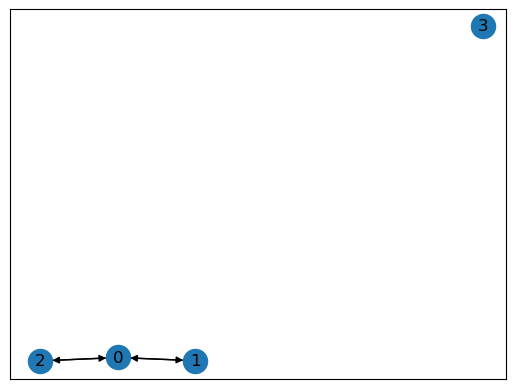

In [12]:
vis = to_networkx(graph)
nx.draw_networkx(vis)

In [13]:
def convert_to_adj(edge_index, num_nodes=None):
    if num_nodes is None:
        num_nodes = edge_index.max() + 1
    adj = torch.zeros(num_nodes, num_nodes)
    adj[edge_index[0], edge_index[1]] = 1
    return adj

def convert_to_edge_index(adj):
    edge_index = adj.nonzero().t()
    return edge_index

In [14]:
graphs = []
n_graphs = 5000

In [15]:
all_features = []
real_node_features = []

for i in range(n_graphs):
    rotated = rotate3D(node_features,np.random.uniform(0,2*np.pi),np.random.uniform(0,2*np.pi),np.random.uniform(0,2*np.pi))
    real_node_features.append(rotated)

    noisy_node_features = rotated + np.random.normal(0,0.1,rotated.shape)

    all_features.append(noisy_node_features)
    real_node_features.append(rotated)

all_features = np.array(all_features)    
real_node_features = np.array(real_node_features)

In [16]:
scaler = MinMaxScaler()
scaler.fit(all_features.reshape(-1,1))
normalized_node_features = scaler.transform(all_features.reshape(-1,1)).reshape(all_features.shape)

normalized_real_node_features = scaler.transform(real_node_features.reshape(-1,1)).reshape(real_node_features.shape)


In [17]:
for x,y in zip(normalized_node_features,normalized_real_node_features):
    graph = data.Data(x=torch.from_numpy(x),edge_index=torch.from_numpy(edge_list),y=torch.from_numpy(y))
    graphs.append(graph)
    

In [18]:
graphs[0]

Data(x=[4, 5], edge_index=[2, 4], y=[4, 5])

In [19]:
from typing import Callable, List, Union

import torch
from torch import Tensor

from torch_geometric.nn import GCNConv, TopKPooling
from torch_geometric.nn.resolver import activation_resolver
from torch_geometric.typing import OptTensor, PairTensor
from torch_geometric.utils import (
    add_self_loops,
    remove_self_loops,
    to_torch_csr_tensor,
)
from torch_geometric.utils.repeat import repeat


class GraphUNet(torch.nn.Module):
    r"""The Graph U-Net model from the `"Graph U-Nets"
    <https://arxiv.org/abs/1905.05178>`_ paper which implements a U-Net like
    architecture with graph pooling and unpooling operations.

    Args:
        in_channels (int): Size of each input sample.
        hidden_channels (int): Size of each hidden sample.
        out_channels (int): Size of each output sample.
        depth (int): The depth of the U-Net architecture.
        pool_ratios (float or [float], optional): Graph pooling ratio for each
            depth. (default: :obj:`0.5`)
        sum_res (bool, optional): If set to :obj:`False`, will use
            concatenation for integration of skip connections instead
            summation. (default: :obj:`True`)
        act (torch.nn.functional, optional): The nonlinearity to use.
            (default: :obj:`torch.nn.functional.relu`)
    """
    def __init__(
        self,
        in_channels: int,
        hidden_channels: int,
        out_channels: int,
        depth: int,
        pool_ratios: Union[float, List[float]] = 0.5,
        sum_res: bool = True,
        act: Union[str, Callable] = 'relu',
    ):
        super().__init__()
        assert depth >= 1
        self.in_channels = in_channels
        self.hidden_channels = hidden_channels
        self.out_channels = out_channels
        self.depth = depth
        self.pool_ratios = repeat(pool_ratios, depth)
        self.act = activation_resolver(act)
        self.sum_res = sum_res

        channels = hidden_channels

        self.down_convs = torch.nn.ModuleList()
        self.pools = torch.nn.ModuleList()
        self.down_convs.append(GCNConv(in_channels, channels, improved=True))
        for i in range(depth):
            self.pools.append(TopKPooling(channels, self.pool_ratios[i]))
            self.down_convs.append(GCNConv(channels, channels, improved=True))

        in_channels = channels if sum_res else 2 * channels

        self.up_convs = torch.nn.ModuleList()
        for i in range(depth - 1):
            self.up_convs.append(GCNConv(in_channels, channels, improved=True))
        self.up_convs.append(GCNConv(in_channels, out_channels, improved=True))

        self.reset_parameters()

    def reset_parameters(self):
        r"""Resets all learnable parameters of the module."""
        for conv in self.down_convs:
            conv.reset_parameters()
        for pool in self.pools:
            pool.reset_parameters()
        for conv in self.up_convs:
            conv.reset_parameters()

    def forward(self, x: Tensor, edge_index: Tensor,
                batch: OptTensor = None) -> Tensor:
        """"""
        if batch is None:
            batch = edge_index.new_zeros(x.size(0))
        edge_weight = x.new_ones(edge_index.size(1))

        x = self.down_convs[0](x, edge_index, edge_weight)
        x = self.act(x)

        xs = [x]
        edge_indices = [edge_index]
        edge_weights = [edge_weight]
        perms = []
        encoded = None
        for i in range(1, self.depth + 1):
            edge_index, edge_weight = self.augment_adj(edge_index, edge_weight,
                                                       x.size(0))
            x, edge_index, edge_weight, batch, perm, _ = self.pools[i - 1](
                x, edge_index, edge_weight, batch)

            x = self.down_convs[i](x, edge_index, edge_weight)
            x = self.act(x)

            if i < self.depth:
                xs += [x]
                edge_indices += [edge_index]
                edge_weights += [edge_weight]
            perms += [perm]
        encoded = x
        for i in range(self.depth):
            j = self.depth - 1 - i

            res = xs[j]
            edge_index = edge_indices[j]
            edge_weight = edge_weights[j]
            perm = perms[j]

            up = torch.zeros_like(res)
            up[perm] = x
            x = res + up if self.sum_res else torch.cat((res, up), dim=-1)

            x = self.up_convs[i](x, edge_index, edge_weight)
            x = self.act(x) if i < self.depth - 1 else x

        return x,encoded

    def augment_adj(self, edge_index: Tensor, edge_weight: Tensor,
                    num_nodes: int) -> PairTensor:
        edge_index, edge_weight = remove_self_loops(edge_index, edge_weight)
        edge_index, edge_weight = add_self_loops(edge_index, edge_weight,
                                                 num_nodes=num_nodes)
        adj = to_torch_csr_tensor(edge_index, edge_weight,
                                  size=(num_nodes, num_nodes))
        adj = (adj @ adj).to_sparse_coo()
        edge_index, edge_weight = adj.indices(), adj.values()
        edge_index, edge_weight = remove_self_loops(edge_index, edge_weight)
        return edge_index, edge_weight

    def __repr__(self) -> str:
        return (f'{self.__class__.__name__}({self.in_channels}, '
                f'{self.hidden_channels}, {self.out_channels}, '
                f'depth={self.depth}, pool_ratios={self.pool_ratios})')

In [20]:
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
input_dim=graph.x.size(-1)
output_dim=graph.y.size(-1)
hidden_channels=4
depth=10

In [21]:
graph.num_features

5

In [22]:
import os


in_channels = graph.num_features
out_channels = 2
lr = 1e-3
n_epochs = 100
batch_size=64
test_train_split = 0.8
model_name = "GUNET_v1.pt"
model_loaded = False
force_train = True

In [23]:
model=GraphUNet(input_dim, hidden_channels, output_dim,depth)
split = int(test_train_split * len(graphs))
train_loader = DataLoader(graphs[:split], batch_size=batch_size)
test_loader = DataLoader(graphs[split:], batch_size=batch_size)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)

In [24]:
lossFxn = torch.nn.MSELoss()
def train():
    model.train()
    model.double()
    loss_all = 0
    feature_loss_all = 0
    position_loss_all = 0

    for data in train_loader:
        optimizer.zero_grad()
        decoded_x , z = model.forward(data.x, data.edge_index)
        
        decoded_pos = decoded_x[:,:3]
        decoded_features = decoded_x[:,3:]
        orignal_pos = data.x[:,:3]
        orignal_features = data.x[:,3:]

        positionLoss = lossFxn(decoded_pos, orignal_pos)
        FeatureLoss = lossFxn(decoded_features, orignal_features)

        loss = FeatureLoss + 2*positionLoss
        
        loss_all +=  float(loss)
        feature_loss_all += float(FeatureLoss)
        position_loss_all += float(positionLoss)

        loss.backward()
        optimizer.step()

    return loss_all / len(train_loader), feature_loss_all / len(train_loader), position_loss_all / len(train_loader)

In [25]:
lossFxn = torch.nn.MSELoss()
def test():
    model.eval()
    model.double()
    loss_all = 0
    feature_loss_all = 0
    position_loss_all = 0

    for data in test_loader:
        optimizer.zero_grad()
        decoded_x , z = model.forward(data.x, data.edge_index)
        
        decoded_pos = decoded_x[:,:3]
        decoded_features = decoded_x[:,3:]
        orignal_pos = data.x[:,:3]
        orignal_features = data.x[:,3:]

        positionLoss = lossFxn(decoded_pos, orignal_pos)
        FeatureLoss = lossFxn(decoded_features, orignal_features)

        loss = FeatureLoss + 2*positionLoss
        
        loss_all +=  float(loss)
        feature_loss_all += float(FeatureLoss)
        position_loss_all += float(positionLoss)

    return loss_all / len(test_loader), feature_loss_all / len(test_loader), position_loss_all / len(test_loader)

In [26]:
train_total_losses = []
train_feature_losses = []
train_edge_losses = []
train_kl_losses = []
train_position_losses = []

test_total_losses = []
test_feature_losses = []
test_edge_losses = []
test_kl_losses = []
test_position_losses = []




for epoch in range(1, n_epochs + 1):
    train_total_loss, train_feature_loss ,train_position_loss = train()
    test_total_loss, test_feature_loss ,test_position_loss = test()
    
    print(f"Epoch: {epoch:03d}  LR: {scheduler.get_last_lr()[0]:.6f}")
    print(f'\tTrain:\tTotal Loss: {train_total_loss:.4f}, Feature Loss: {train_feature_loss:.4f}, Position Loss: {train_position_loss:.4f}')
    print(f'\tTest:\tTotal Loss: {test_total_loss:.4f}, Feature Loss: {test_feature_loss:.4f}, Position Loss: {test_position_loss:.4f}')

    train_total_losses.append(train_total_loss)
    train_feature_losses.append(train_feature_loss)
    train_position_losses.append(train_position_loss)

    test_total_losses.append(test_total_loss)
    test_feature_losses.append(test_feature_loss)
    test_position_losses.append(test_position_loss)
    

    scheduler.step()

    torch.save(model,"./models/"+model_name)

/home/imami/anaconda3/lib/python3.10/site-packages/torch_geometric/utils/sparse.py:176: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at /opt/conda/conda-bld/pytorch_1682343904639/work/aten/src/ATen/SparseCsrTensorImpl.cpp:54.)
  return adj.to_sparse_csr()


Epoch: 001  LR: 0.001000
	Train:	Total Loss: 0.4448, Feature Loss: 0.1479, Position Loss: 0.1484
	Test:	Total Loss: 0.3026, Feature Loss: 0.0870, Position Loss: 0.1078
Epoch: 002  LR: 0.001000
	Train:	Total Loss: 0.2261, Feature Loss: 0.0627, Position Loss: 0.0817
	Test:	Total Loss: 0.1683, Feature Loss: 0.0444, Position Loss: 0.0619
Epoch: 003  LR: 0.001000
	Train:	Total Loss: 0.1346, Feature Loss: 0.0340, Position Loss: 0.0503
	Test:	Total Loss: 0.1095, Feature Loss: 0.0252, Position Loss: 0.0422
Epoch: 004  LR: 0.001000
	Train:	Total Loss: 0.0950, Feature Loss: 0.0201, Position Loss: 0.0374
	Test:	Total Loss: 0.0852, Feature Loss: 0.0163, Position Loss: 0.0344
Epoch: 005  LR: 0.001000
	Train:	Total Loss: 0.0803, Feature Loss: 0.0142, Position Loss: 0.0331
	Test:	Total Loss: 0.0770, Feature Loss: 0.0121, Position Loss: 0.0324
Epoch: 006  LR: 0.001000
	Train:	Total Loss: 0.0750, Feature Loss: 0.0109, Position Loss: 0.0321
	Test:	Total Loss: 0.0734, Feature Loss: 0.0095, Position Loss:

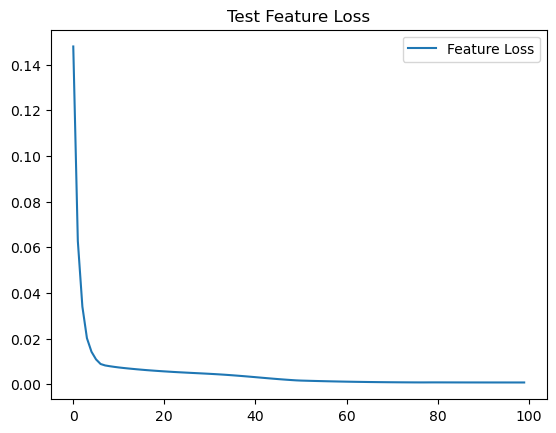

In [27]:
plt.plot(train_feature_losses)

plt.title("Test Feature Loss")
plt.legend(['Feature Loss', 'KL Loss'])
plt.show()

Text(0.5, 1.0, 'Test Position Loss')

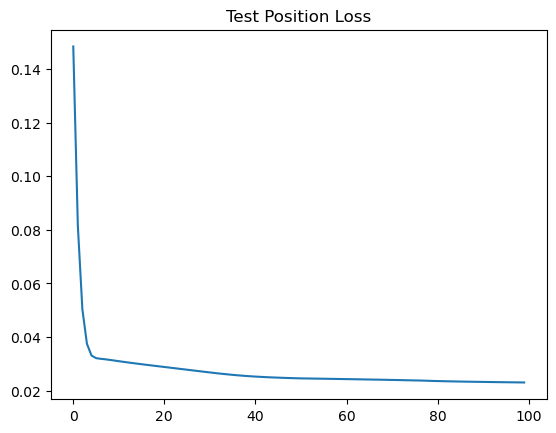

In [28]:
plt.plot(train_position_losses)
plt.title("Test Position Loss")


In [29]:
from torch.functional import F
avg1 = 0
avg2 = 0
for ind in range(len(test_loader)):
    graph = test_loader.dataset[ind]
    input_x = graph.x
    input_edge = graph.edge_index

    decoded_x , z = model.forward(input_x, input_edge)

    Error_wo_s = F.mse_loss(decoded_x, input_x).detach().numpy()

    decoded_x = scaler.inverse_transform(decoded_x.detach().numpy())
    input_x = scaler.inverse_transform(graph.x.detach().numpy())

    Error_af_s = F.mse_loss(torch.from_numpy(decoded_x), torch.from_numpy(input_x)).detach().numpy()

    z = z.detach().numpy()

    avg1 += Error_wo_s
    avg2 += Error_af_s
    # print(input_x)
# print(z)
# print(decoded_x)

print("Average Error without scaling", avg1/len(test_loader))
print("Average Error with scaling", avg2/len(test_loader))

Average Error without scaling 0.014349208287476703
Average Error with scaling 5.107797155526981
